## Machine Learning for Neuroscience, <br>Department of Brain Sciences, Faculty of Medicine, <br> Imperial College London
### Contributors: Alex Capstick, Francesca Palermo, Nan Fletcher-Lloyd, Yu Chen, Tianyu Cui, Marirena Bafaloukou, Ruxandra Mihai, Payam Barnaghi
**Spring 2024**


# Pytorch

In [1]:
import numpy as np
import pandas as pd
import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata

import sklearn.metrics as skmetrics

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")

# mps is for apple but is slower here
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")

else:
    device = torch.device("cpu")

In [3]:
torch.manual_seed(16)

## What does pytorch do?

The main point of pytorch is to provide a tensor library that can be used for automatic differentiation. This is useful for machine learning, where you want to compute gradients of a loss function with respect to the parameters of a model. Pytorch also provides a module for building neural networks, which is built on top of the tensor library.

In numpy:

In [4]:
x = np.array([1,2,3,4])
x

array([1, 2, 3, 4])

In [5]:
x+x

array([2, 4, 6, 8])

In [6]:
2*x

array([2, 4, 6, 8])

The same can be done in pytorch:

In [7]:
t = torch.from_numpy(x)

In [8]:
t + t

tensor([2, 4, 6, 8])

In [9]:
2*t

tensor([2, 4, 6, 8])

But the interesting part comes when we start to compute gradients. In numpy, we would have to write out the gradient function by hand.

Let's say I want to times x by 2, then add 3, then square it, then sum it. To tell pytorch to do the automatic differentiation, we use the `requires_grad` flag.


In [10]:
t = torch.from_numpy(x).float().requires_grad_(True)

Times x by 2, then add 3, then square it, then sum it:

In [11]:
result = torch.sum(( 2*t + 3)**2)
result

tensor(276., grad_fn=<SumBackward0>)

Now watch! If we call `.backward()` on the output, it will compute the gradient of the output with respect to everything that has `requires_grad=True`.

In [12]:
result.backward()

The gradients are stored in the `.grad` attribute of each tensor.

In [13]:
t.grad

tensor([20., 28., 36., 44.])

This is the basic idea, since it allows us to calculate the contributions of each parameter to the loss function, we can then use gradient descent to optimize the parameters.

## Loading Data:

We need to be able to calculate the gradients of the loss with respect to the weights. We therefore need data to train our network on! Loading data in pytorch is easy. Here, we will use Sklearns `make_moons` function to generate some data.

Our fake data:

In [14]:
from sklearn.datasets import make_moons

In [15]:
X, y = make_moons(n_samples=10000, noise=0.1, random_state=42)

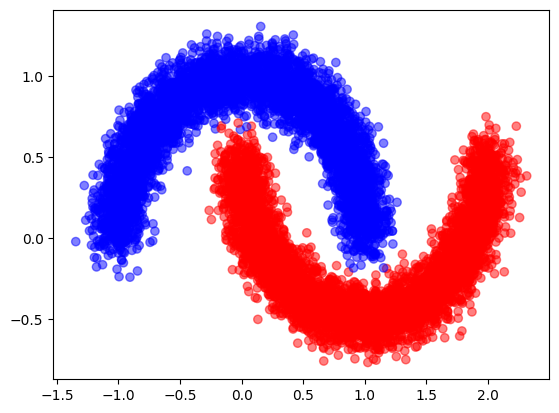

In [16]:
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.5)

In [17]:
X_train, y_train = X[:8000], y[:8000]
X_test, y_test = X[8000:], y[8000:]

In Pytorch, we use a `Dataset` object to store our data. We can then use a `DataLoader` to iterate over the data in batches.

In [18]:
train_dataset = torchdata.TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train)
)

test_dataset = torchdata.TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test)
)

This wraps our data into a neat object that we can index to get our data. These classes can also be used to load data from disk, or from a database, as we will see later.

In [19]:
train_dataset[0]
# outputs a tuple of (X, y)

(tensor([ 0.4555, -0.1255]), tensor(1))

There is also functionality in pytorch to load subsets from data, chain datasets, or sample from them. Below, we will create a validation set by random splitting the training dataset.

In [20]:
train_dataset, val_dataset = torchdata.random_split(train_dataset, [6000, 2000])

In [21]:
print("The length of the training dataset is", len(train_dataset))
print("The length of the validation dataset is", len(val_dataset))

The length of the training dataset is 6000
The length of the validation dataset is 2000


Once we have done this, we can use the `DataLoader` to iterate over the data in batches. This is useful for training neural networks, as we can use stochastic gradient descent to train the network. For fun, we will add a weighted sampler to sample from the positive class twice as often.

In [22]:
train_targets = torch.tensor([y.item() for _, y in train_dataset])

weights = torch.ones_like(train_targets, dtype=torch.float)
weights = weights.masked_fill(train_targets == 1, 2)

We can build a sampler:

In [23]:
sampler = torchdata.WeightedRandomSampler(
    weights, len(train_dataset), 
    replacement=True, 
)

Since we set the replacement to true, and the number of samples to be the length of the dataset, we are getting a weighted bootstrap sample. We can then use this sampler to build a dataloader.

In [24]:
train_dl = torchdata.DataLoader(
    train_dataset, batch_size=8, sampler=sampler
)
val_dl = torchdata.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dl = torchdata.DataLoader(test_dataset, batch_size=8, shuffle=False)

Since we set a sampler, we can't set shuffle to true. This is because the sampler is responsible for shuffling the data.

To get a batch of data, we can just iterate over the dataloader and break on the first iteration. By doing this we can look at our batch shapes:

In [25]:
for b in train_dl:
    break

In [26]:
print("The batch is a tuple of length", len(b))
print("The batch contains the following tensors:")
print("\tX:", b[0].shape)
print("\ty:", b[1].shape)

The batch is a tuple of length 2
The batch contains the following tensors:
	X: torch.Size([8, 2])
	y: torch.Size([8])


## Building a neural network:

Let's build a very simple Neural Network for this task so that we can see how loss functions, optimizers, and neural networks are built in pytorch.

To start, we need to think about our targets and how we want to measure our mistakes. Because this is a classification task, we will use [Cross Entropy Loss](https://en.wikipedia.org/wiki/Cross-entropy).

Because this is a tutorial, we will define it from scrath. In practice, you would use the built in loss functions - namely here `torch.nn.CrossEntropyLoss`.

In [27]:
# you will learn about this loss later
def cross_entropy(preds, targets):
    preds = F.softmax(preds, dim=1)
    return -(
        torch.ones_like(targets) 
        * torch.log(
            preds[torch.arange(len(targets)), targets]
        )
    )

Let's test it against the built in loss function:

In [28]:
logits = torch.tensor([[0.1, 0.9]])
targets = torch.tensor([1])

In [29]:
# ours:
cross_entropy(logits, targets)

tensor([0.3711])

In [30]:
# pytorch:
F.cross_entropy(logits, targets)

tensor(0.3711)

Yay! It works! Now we can build a neural network. We will build a simple feed forward network with 2 hidden layers. We will use the `torch.nn` module to build our network. We will see this in more detail later, but for now, we will just use the `torch.nn.Sequential` module to build our network.

In [31]:
net = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 2),
)

Now, if we put our batch through the model, we get:

In [32]:
net(b[0])

tensor([[ 0.1991,  0.1789],
        [ 0.1896,  0.1837],
        [ 0.0416,  0.2584],
        [-0.2201,  0.3905],
        [ 0.0264,  0.2661],
        [-0.2181,  0.3895],
        [-0.1881,  0.3744],
        [-0.1121,  0.3360]], grad_fn=<AddmmBackward0>)

But the true labels were:

In [33]:
b[1]

tensor([0, 0, 1, 1, 0, 1, 1, 1])

If we take a softmax of the output, we can think about these as a probability distribution over the classes. The first column gives us the probability of the first class, and the second column gives us the probability of the second class. Here, we can take an argmax of the model to get the predicted classes.

In [34]:
net(b[0]).softmax(dim=1).argmax(dim=1)

tensor([0, 0, 1, 1, 1, 1, 1, 1])

Pretty bad so far... Let's see what the cross entropy loss is:

In [35]:
y_pred_logits = net(b[0])

In [36]:
b[1]

tensor([0, 0, 1, 1, 0, 1, 1, 1])

In [37]:
loss = cross_entropy(
    y_pred_logits,
    b[1]
)
loss

tensor([0.6831, 0.6902, 0.5906, 0.4337, 0.8201, 0.4348, 0.4509, 0.4940],
       grad_fn=<NegBackward0>)

In [38]:
correct = 0
total = 0

for b in test_dl:
    # get the predictions
    test_logits = net(b[0])
    test_preds = test_logits.softmax(dim=1).argmax(dim=1)

    # update the counts
    correct += (test_preds == b[1]).sum().item()
    total += len(b[1])

print("the accuracy on the test set before training is", f"{correct/total*100:.2f}%")

the accuracy on the test set before training is 59.65%


Now this is where the magic happens. Let's say we now want to calculate the gradient of the loss with respect to the weights in our model. We can do this by calling `.backward()` on the loss. Except that we need to calculate the mean or sum of our losses over our batch first, since we can only calculate the gradient of a scalar with respect to a vector.

In [39]:
loss = loss.mean()
loss

tensor(0.5747, grad_fn=<MeanBackward0>)

And gradients!

In [40]:
loss.backward()

What did this do? Well, if we look at the weights of our `net`, we can see they now have gradients:

In [41]:
for n, p in net.named_parameters():
    print('name:', n, '\nparameters:', p, '\ngradients:', p.grad)
    print('----')

name: 0.weight 
parameters: Parameter containing:
tensor([[-0.6771, -0.6952],
        [-0.0807, -0.0956],
        [ 0.1137, -0.2895],
        [ 0.2879, -0.2602],
        [-0.1124,  0.4764]], requires_grad=True) 
gradients: tensor([[ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.1999,  0.1156],
        [ 0.0000,  0.0000]])
----
name: 0.bias 
parameters: Parameter containing:
tensor([-0.2907, -0.6382, -0.5393,  0.4584, -0.6889], requires_grad=True) 
gradients: tensor([ 0.0000,  0.0000,  0.0000, -0.0289,  0.0000])
----
name: 2.weight 
parameters: Parameter containing:
tensor([[-0.3639, -0.0545, -0.1293, -0.4384,  0.3091],
        [ 0.0206, -0.0974,  0.0895,  0.2213,  0.2163]], requires_grad=True) 
gradients: tensor([[ 0.0000,  0.0000,  0.0000,  0.1529,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.1529,  0.0000]])
----
name: 2.bias 
parameters: Parameter containing:
tensor([0.2302, 0.1632], requires_grad=True) 
gradients: tensor([ 0.0438, -0.0438

How do we use these gradients to update our weights? We use an optimizer! Pytorch has a number of optimizers built in, but we will use the simplest one - Stochastic Gradient Descent.

Let's do this again. We start by setting the gradients to zero, then we calculate the loss on a batch, then we call `.backward()` on the loss, then we call `.step()` on the optimizer. We will also pass everything to the device, whichever is available!

In [42]:
net = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 2),
)
net.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=2, bias=True)
)

In [43]:
optimiser = torch.optim.SGD(net.parameters(), lr=0.01)

/Users/ac4919/miniforge3/envs/ml4ns/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
optimiser.zero_grad()

In [45]:
loss = cross_entropy(
    net(b[0].to(device)),
    b[1].to(device)
).mean()
loss

tensor(0.7397, grad_fn=<MeanBackward0>)

Currently no gradients:

In [46]:
for n, p in net.named_parameters():
    print('name:', n, '\nparameters:', p, '\ngradients:', p.grad)
    print('----')

name: 0.weight 
parameters: Parameter containing:
tensor([[-0.3563, -0.4552],
        [ 0.2094,  0.2204],
        [ 0.4883, -0.4102],
        [ 0.2901, -0.0184],
        [ 0.2303,  0.4271]], requires_grad=True) 
gradients: None
----
name: 0.bias 
parameters: Parameter containing:
tensor([-0.1609,  0.6199, -0.1208,  0.1880, -0.6537], requires_grad=True) 
gradients: None
----
name: 2.weight 
parameters: Parameter containing:
tensor([[ 0.1942,  0.4437, -0.1197,  0.4207,  0.4257],
        [ 0.2550,  0.3639, -0.4416,  0.2399,  0.1330]], requires_grad=True) 
gradients: None
----
name: 2.bias 
parameters: Parameter containing:
tensor([0.2364, 0.1105], requires_grad=True) 
gradients: None
----


In [47]:
loss.backward()

Now gradients:

In [48]:
for n, p in net.named_parameters():
    print('name:', n, '\nparameters:', p, '\ngradients:', p.grad)
    print('----')

name: 0.weight 
parameters: Parameter containing:
tensor([[-0.3563, -0.4552],
        [ 0.2094,  0.2204],
        [ 0.4883, -0.4102],
        [ 0.2901, -0.0184],
        [ 0.2303,  0.4271]], requires_grad=True) 
gradients: tensor([[ 0.0000,  0.0000],
        [ 0.0070, -0.0040],
        [ 0.0060, -0.0270],
        [ 0.0058, -0.0044],
        [ 0.0000,  0.0000]])
----
name: 0.bias 
parameters: Parameter containing:
tensor([-0.1609,  0.6199, -0.1208,  0.1880, -0.6537], requires_grad=True) 
gradients: tensor([0.0000, 0.0155, 0.0140, 0.0455, 0.0000])
----
name: 2.weight 
parameters: Parameter containing:
tensor([[ 0.1942,  0.4437, -0.1197,  0.4207,  0.4257],
        [ 0.2550,  0.3639, -0.4416,  0.2399,  0.1330]], requires_grad=True) 
gradients: tensor([[ 0.0000,  0.1275,  0.0382,  0.0570,  0.0000],
        [ 0.0000, -0.1275, -0.0382, -0.0570,  0.0000]])
----
name: 2.bias 
parameters: Parameter containing:
tensor([0.2364, 0.1105], requires_grad=True) 
gradients: tensor([ 0.1940, -0.1940])
--

Now we take a step:

In [49]:
optimiser.step()

In [50]:
for n, p in net.named_parameters():
    print('name:', n, '\nparameters:', p, '\ngradients:', p.grad)
    print('----')

name: 0.weight 
parameters: Parameter containing:
tensor([[-0.3563, -0.4552],
        [ 0.2094,  0.2205],
        [ 0.4883, -0.4099],
        [ 0.2901, -0.0184],
        [ 0.2303,  0.4271]], requires_grad=True) 
gradients: tensor([[ 0.0000,  0.0000],
        [ 0.0070, -0.0040],
        [ 0.0060, -0.0270],
        [ 0.0058, -0.0044],
        [ 0.0000,  0.0000]])
----
name: 0.bias 
parameters: Parameter containing:
tensor([-0.1609,  0.6198, -0.1210,  0.1875, -0.6537], requires_grad=True) 
gradients: tensor([0.0000, 0.0155, 0.0140, 0.0455, 0.0000])
----
name: 2.weight 
parameters: Parameter containing:
tensor([[ 0.1942,  0.4424, -0.1200,  0.4202,  0.4257],
        [ 0.2550,  0.3652, -0.4413,  0.2404,  0.1330]], requires_grad=True) 
gradients: tensor([[ 0.0000,  0.1275,  0.0382,  0.0570,  0.0000],
        [ 0.0000, -0.1275, -0.0382, -0.0570,  0.0000]])
----
name: 2.bias 
parameters: Parameter containing:
tensor([0.2345, 0.1125], requires_grad=True) 
gradients: tensor([ 0.1940, -0.1940])
--

Since our learning rate is small, we don't see much change. Let's do this a few more times:

In [51]:
n_updates = 100000

# remove old pbars if they exist
tqdm.tqdm._instances.clear()

val_loss_dict = {}

# iterating over the number of updates
for i in tqdm.trange(n_updates, desc="Training", unit="update"):
    
    # next batch
    b = next(iter(train_dl))

    # zero the gradients
    optimiser.zero_grad()

    # forward pass
    loss = cross_entropy(
        net(b[0].to(device)),
        b[1].to(device)
    ).mean()
    
    # backward pass
    loss.backward()

    # update the weights
    optimiser.step()

    # print the loss and val loss every 10000 steps
    if i % 10000 == 0:
        
        n_points = 0
        # calculate the val loss
        for b in val_dl:
            val_loss = cross_entropy(
                net(b[0].to(device)),
                b[1].to(device)
            ).sum()

            n_points += len(b[1])

        val_loss_dict[i] = val_loss.item()/n_points
        
        print("Mean of Validation loss at update", i, "is", f"{val_loss.item():.2f}")

Training:   0%|          | 87/100000 [00:00<01:55, 865.02update/s]

Mean of Validation loss at update 0 is 6.00


Training:   1%|          | 1073/100000 [00:00<01:30, 1095.61update/s]

Training:  10%|█         | 10217/100000 [00:07<00:57, 1559.18update/s]

Mean of Validation loss at update 10000 is 0.62


Training:  20%|██        | 20231/100000 [00:13<00:51, 1556.29update/s]

Mean of Validation loss at update 20000 is 0.24


Training:  30%|███       | 30181/100000 [00:19<00:45, 1543.82update/s]

Mean of Validation loss at update 30000 is 0.20


Training:  40%|████      | 40101/100000 [00:25<00:51, 1163.03update/s]

Mean of Validation loss at update 40000 is 0.20


Training:  50%|█████     | 50154/100000 [00:33<00:34, 1452.88update/s]

Mean of Validation loss at update 50000 is 0.19


Training:  60%|██████    | 60241/100000 [00:39<00:25, 1539.22update/s]

Mean of Validation loss at update 60000 is 0.19


Training:  70%|███████   | 70174/100000 [00:45<00:19, 1559.34update/s]

Mean of Validation loss at update 70000 is 0.18


Training:  80%|████████  | 80183/100000 [00:51<00:12, 1565.68update/s]

Mean of Validation loss at update 80000 is 0.15


Training:  90%|█████████ | 90175/100000 [00:58<00:06, 1560.39update/s]

Mean of Validation loss at update 90000 is 0.18


Training: 100%|██████████| 100000/100000 [01:04<00:00, 1557.72update/s]


Let us look at the loss over time:

Text(0.5, 1.0, 'Validation Loss Over Time')

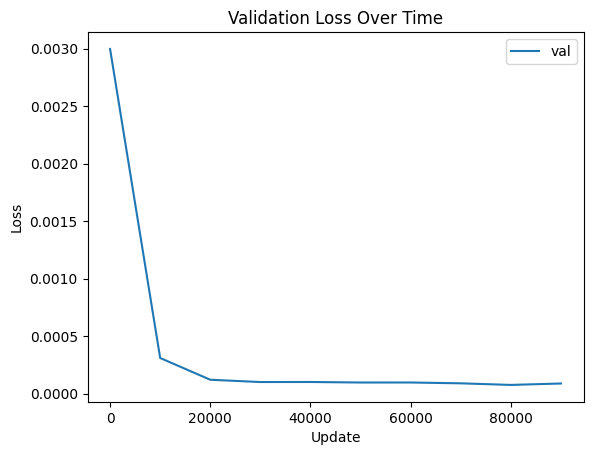

In [52]:
fig, ax = plt.subplots()

ax.plot(
    list(val_loss_dict.keys()),
    list(val_loss_dict.values()),
    label="val"
)

ax.set_xlabel("Update")
ax.set_ylabel("Loss")
ax.legend()
ax.set_title("Validation Loss Over Time")

Let's calculate the accuracy over the test set:

In [53]:
correct = 0
total = 0

for b in test_dl:
    # get the predictions
    test_logits = net(b[0].to(device))
    test_preds = test_logits.softmax(dim=1).argmax(dim=1)

    # update the counts
    correct += (test_preds == b[1].to(device)).sum().item()
    total += len(b[1])

print("the accuracy on the test set after training is", f"{correct/total*100:.2f}%")

the accuracy on the test set after training is 97.95%


As we can see, our model is not that bad, and it is relatively simple, only containg a few parameters

In [54]:
num_params = 0

# iterate over the parameters
for n, p in net.named_parameters():
    num_params += p.numel()
    print('name:', n, '\nparameters:', p.numel())
    print('----')

print("The total number of parameters in the network is", num_params)

name: 0.weight 
parameters: 10
----
name: 0.bias 
parameters: 5
----
name: 2.weight 
parameters: 10
----
name: 2.bias 
parameters: 2
----
The total number of parameters in the network is 27


We can also use some sklearn functions to view the decision boundary. Although this is less meaningful when your number of dimensions increases.

In [55]:
x_lims = X[:,0].min(), X[:,0].max()
y_lims = X[:,1].min(), X[:,1].max()

xx0, xx1 = torch.meshgrid(torch.linspace(*x_lims,steps=101), torch.linspace(*y_lims,steps=101), indexing='ij')

In [56]:
y_proba = net(
    torch.stack([xx0.reshape(-1), xx1.reshape(-1)], dim=1).to(device)
).softmax(dim=1).detach().cpu().numpy()

In [57]:
from sklearn.inspection import DecisionBoundaryDisplay

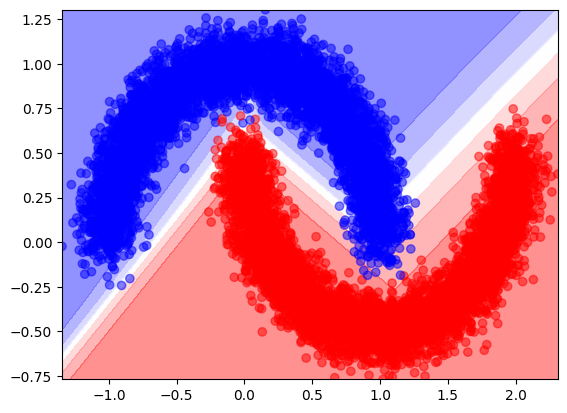

In [58]:
fig, ax = plt.subplots()

ax = DecisionBoundaryDisplay(
    xx0=xx0.detach().numpy(),
    xx1=xx1.detach().numpy(),
    response=y_proba[:,1].reshape(xx0.shape)
).plot(ax=ax, alpha=0.5, cmap='bwr').ax_

ax.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.5)